In [0]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import operator
from torch.nn import init
from torch import nn
import torch.nn.functional as F
from functools import partial
from torch import optim

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'


def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)

def test_near(a,b): test(a,b,near)  
  
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

def normalize(x, m, s): return (x-m)/s

def test_near_zero(a,tol=1e-3): assert a.abs()<tol, f"Near zero: {a}"
  
def mse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean()

class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self,i): return self.x[i],self.y[i]

from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
        DataLoader(valid_ds, batch_size=bs*2, **kwargs))
    
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c
        
    @property
    def train_ds(self): return self.train_dl.dataset
        
    @property
    def valid_ds(self): return self.valid_dl.dataset

def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')

def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner
  
class Callback():
    _order=0
    def set_runner(self, run): self.run = run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property 
    def name(self):
      name = re.sub(r'Callback$','', self.__class__.__name__)
      return camel2snake(name or 'callback')

from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, Iterable): return list(o)
    return [o]

class AvgStats():
  def __init__(self, metrics, in_train): self.metrics, self.in_train = listify(metrics), in_train
    
  def reset(self):
    self.tot_loss, self.count = 0., 0
    self.tot_mets = [0.]*len(self.metrics)
    
  @property
  def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
  
  @property
  def avg_stats(self): return [o/self.count for o in self.all_stats]
  
  def __repr__(self):
    if not self.count: return ""
    return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"
  
  def accumulate(self, run):
    bn = run.xb.shape[0]
    self.tot_loss += run.loss*bn
    self.count += bn
    for i,m in enumerate(self.metrics):
      self.tot_mets[i] += m(run.pred, run.yb)*bn
      
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

def get_model_func(lr=0.5): return partial(get_model, lr=lr)

class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))


#export
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb,yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res

        #export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

        
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)


    #export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()


class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())


class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)


#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

# Layerwise Sequential Unit Variance (LSUV)


Getting the MNIST data and a CNN

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [0]:
nfs = [8,16,32,64,64]

In [0]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2, sub=0., **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True)
        self.relu = GeneralRelu(sub=sub, **kwargs)
    
    def forward(self, x): return self.relu(self.conv(x))
    
    @property
    def bias(self): return -self.relu.sub
    @bias.setter
    def bias(self,v): self.relu.sub = -v
    @property
    def weight(self): return self.conv.weight

In [0]:
learn,run = get_learn_run(nfs, data, 0.6, ConvLayer, cbs=cbfs)

In [0]:
#export
def get_batch(dl, run):
    run.xb,run.yb = next(iter(dl))
    for cb in run.cbs: cb.set_runner(run)
    run('begin_batch')
    return run.xb,run.yb

In [0]:
xb,yb = get_batch(data.train_dl, run)

In [0]:
#export
def find_modules(m, cond):
    if cond(m): return [m]
    return sum([find_modules(o,cond) for o in m.children()], [])

def is_lin_layer(l):
    lin_layers = (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear, nn.ReLU)
    return isinstance(l, lin_layers)

In [0]:
mods = find_modules(learn.model, lambda o: isinstance(o,ConvLayer))

In [11]:
mods

[ConvLayer(
   (conv): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 )]

In [0]:
def append_stat(hook, mod, inp, outp):
    d = outp.data
    hook.mean,hook.std = d.mean().item(),d.std().item()

In [0]:
mdl = learn.model.cuda()

In [14]:
with Hooks(mods, append_stat) as hooks:
    mdl(xb)
    for hook in hooks: print(hook.mean,hook.std)

0.4595707654953003 1.1042481660842896
0.5158735513687134 1.2597867250442505
0.5918011665344238 1.196776270866394
0.5253881216049194 0.901400625705719
0.2561800181865692 0.45419013500213623


In [0]:
def lsuv_module(m, xb):
    h = Hook(m, append_stat)
    
    while mdl(xb) is not None and abs(h.mean)  > 1e-3: m.bias -= h.mean
    while mdl(xb) is not None and abs(h.std-1) > 1e-3: m.weight.data /= h.std

    
    mdl(xb)
    if(abs(h.mean)  > 1e-2 or abs(h.std-1) > 1e-3):
        h.remove()
        lsuv_module(m, xb)
    h.remove()
    return h.mean,h.std

In [16]:
for m in mods: print(lsuv_module(m, xb))

(-0.04338647797703743, 1.0000001192092896)
(0.006615946535021067, 0.9999999403953552)
(0.07959122955799103, 1.0000001192092896)
(0.1829758882522583, 1.0)
(0.32724177837371826, 1.0000001192092896)



## Data block API foundations

In [17]:
datasets.URLs.IMAGENETTE_160

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160'

In [18]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/root/.fastai/data/imagenette-160')

In [0]:
import PIL,os,mimetypes
Path.ls = lambda x: list(x.iterdir())

In [20]:
path.ls()

[PosixPath('/root/.fastai/data/imagenette-160/val'),
 PosixPath('/root/.fastai/data/imagenette-160/train')]

only contains 10 classes as shown below

In [21]:
(path/'val').ls()

[PosixPath('/root/.fastai/data/imagenette-160/val/n03394916'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03888257'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n02102040'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03425413'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03445777'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03000684'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03028079'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03417042'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n02979186'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764')]

In [0]:
path_tench = path/'val'/'n01440764'

In [23]:
len(path_tench.ls())

50

In [24]:
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00029930.JPEG')

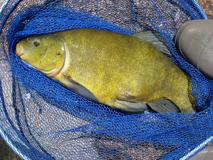

In [25]:
img = PIL.Image.open(img_fn)
img

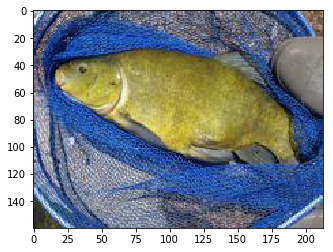

In [26]:

plt.imshow(img)

In [0]:
import numpy
imga = numpy.array(img)

In [28]:
imga.shape

(160, 213, 3)

In [29]:
imga[:10,:10,0]

array([[177, 199, 192, 187, ..., 199, 173,  88,  33],
       [183, 203, 205, 168, ..., 161, 119,  36, 110],
       [185, 170, 155, 191, ..., 201,  85,  55,  90],
       [161, 156, 151, 188, ..., 138,  44, 130, 117],
       ...,
       [155, 221, 235, 120, ...,  57, 100, 103, 114],
       [191, 230, 166, 100, ..., 105, 121,  94,  87],
       [166, 216,  97,  80, ...,  65,  72,  78,  57],
       [232, 207,  90,  48, ...,  70,  99,  97,  73]], dtype=uint8)

In [0]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [31]:
' '.join(image_extensions)

'.jpx .ico .png .tiff .pnm .svg .xpm .jpg .orf .djvu .jpf .tif .bmp .djv .pgm .xwd .pcx .jpm .ras .wbmp .jp2 .ief .jpg2 .cpt .pbm .cdt .erf .ppm .jpeg .jng .nef .psd .xbm .gif .rgb .jpe .svgz .art .cr2 .pat .cdr .crw'

In [0]:
#export
def setify(o): return o if isinstance(o,set) else set(listify(o))


Now let's walk through the directories and grab all the images. The first private function grabs all the images inside a given directory and the second one walks (potentially recursively) through all the folder in path.

In [0]:
#export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res


In [38]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[PosixPath('/root/.fastai/data/imagenette-160/ILSVRC2012_val_00029930.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/ILSVRC2012_val_00040833.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/ILSVRC2012_val_00030740.JPEG')]

In [47]:
path

PosixPath('/root/.fastai/data/imagenette-160')

In [0]:
pdf =  os.walk(path)

In [45]:
for i,(p,d,f) in enumerate(os.walk(path)):
    print(p,d,f)

/root/.fastai/data/imagenette-160 ['val', 'train'] []
/root/.fastai/data/imagenette-160/val ['n03394916', 'n03888257', 'n02102040', 'n03425413', 'n03445777', 'n03000684', 'n03028079', 'n03417042', 'n02979186', 'n01440764'] []
/root/.fastai/data/imagenette-160/val/n03394916 [] ['ILSVRC2012_val_00001492.JPEG', 'ILSVRC2012_val_00009037.JPEG', 'ILSVRC2012_val_00024837.JPEG', 'ILSVRC2012_val_00035433.JPEG', 'ILSVRC2012_val_00019593.JPEG', 'ILSVRC2012_val_00046826.JPEG', 'ILSVRC2012_val_00033682.JPEG', 'ILSVRC2012_val_00030728.JPEG', 'ILSVRC2012_val_00033784.JPEG', 'ILSVRC2012_val_00004301.JPEG', 'ILSVRC2012_val_00028399.JPEG', 'ILSVRC2012_val_00038727.JPEG', 'ILSVRC2012_val_00034826.JPEG', 'ILSVRC2012_val_00011691.JPEG', 'ILSVRC2012_val_00042707.JPEG', 'ILSVRC2012_val_00044598.JPEG', 'ILSVRC2012_val_00025761.JPEG', 'ILSVRC2012_val_00003759.JPEG', 'ILSVRC2012_val_00041242.JPEG', 'ILSVRC2012_val_00015542.JPEG', 'ILSVRC2012_val_00041247.JPEG', 'ILSVRC2012_val_00037592.JPEG', 'ILSVRC2012_val_00

In [0]:
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [48]:
get_files(path_tench, image_extensions)[:3],len(get_files(path_tench, image_extensions))

([PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00029930.JPEG'),
  PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00040833.JPEG'),
  PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00030740.JPEG')],
 50)

In [49]:
get_files(path, image_extensions, recurse=True)[:3],len(get_files(path, image_extensions))

([PosixPath('/root/.fastai/data/imagenette-160/val/n03394916/ILSVRC2012_val_00001492.JPEG'),
  PosixPath('/root/.fastai/data/imagenette-160/val/n03394916/ILSVRC2012_val_00009037.JPEG'),
  PosixPath('/root/.fastai/data/imagenette-160/val/n03394916/ILSVRC2012_val_00024837.JPEG')],
 0)

In [50]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394